In [1]:
import scanpy as sc
import pandas as pd
import pickle
import time
import anndata
import sklearn.metrics
import statistics
import graph_tool.all as gt
%matplotlib notebook
%pylab

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:39: RuntimeWarning: Error importing cairo. Graph drawing will not work.
  warnings.warn(msg, RuntimeWarning)
/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/all.py:40: RuntimeWarning: Error im

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
adata=sc.read('mi_pbmc/adata_base.h5ad')

In [3]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=40)

In [13]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

In [14]:
adata.write('beta_parameter/adata_pbmc.h5ad')

In [2]:
adata=sc.read('beta_parameter/adata_pbmc.h5ad')

In [3]:
g = gt.Graph(directed=False)
adj=adata.uns['neighbors']['connectivities']
edge_weights = g.new_edge_property('double')
g.edge_properties['weight'] = edge_weights
nnz = np.nonzero(np.triu(adj.todense(),1))
nedges = len(nnz[0])
g.add_edge_list(np.hstack([np.transpose(nnz),np.reshape(adj[nnz],(nedges,1))]),eprops=[edge_weights])

In [4]:
pickle.dump(g,open('beta_parameter/g_pbmc.pkl','wb'),2)

In [9]:
a=time.time()
state1=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state2=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
state3=gt.minimize_nested_blockmodel_dl(g, deg_corr=False)
b=time.time()
b-a

287.4225721359253

In [10]:
pickle.dump(state1,open('beta_parameter/state1_pbmc.pkl','wb'),2)
pickle.dump(state2,open('beta_parameter/state2_pbmc.pkl','wb'),2)
pickle.dump(state3,open('beta_parameter/state3_pbmc.pkl','wb'),2)

In [9]:
state1=pickle.load(open('beta_parameter/state1_pbmc.pkl','rb'))
state2=pickle.load(open('beta_parameter/state2_pbmc.pkl','rb'))
state3=pickle.load(open('beta_parameter/state3_pbmc.pkl','rb'))

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


<IPython.core.display.Javascript object>


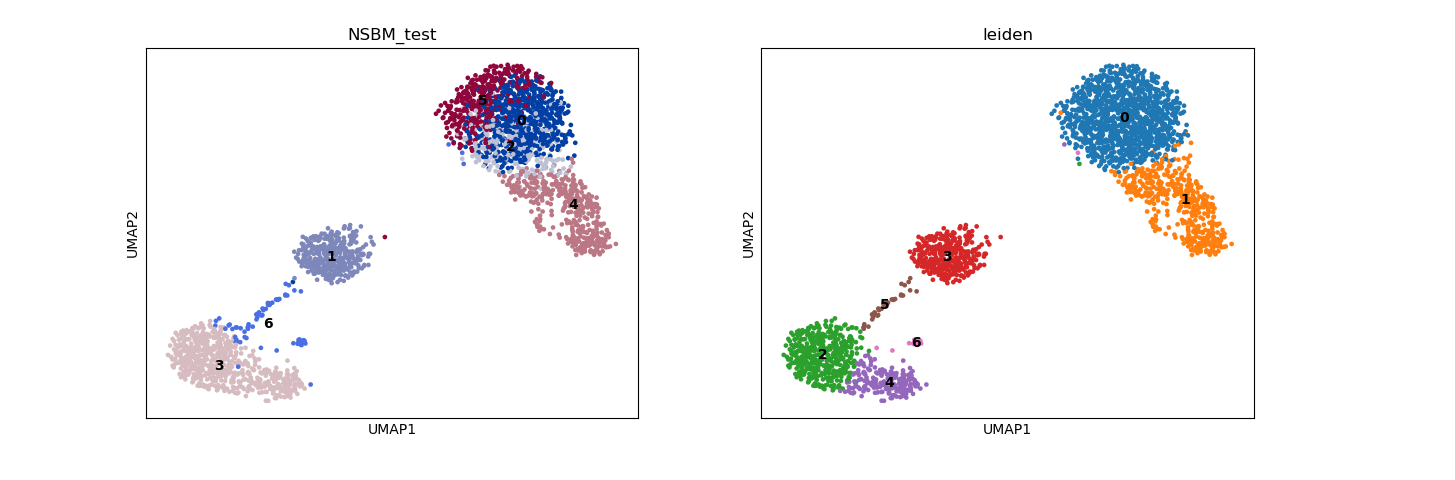

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,631,8,0,0,0,1,0
1,0,0,0,340,0,1,0
2,181,41,0,0,0,0,0
3,0,0,416,0,195,0,0
4,0,397,0,0,0,0,0
5,353,1,0,1,0,0,0
6,0,0,20,0,2,34,16


In [12]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

In [16]:
bs = state2.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=state2.copy(bs=bs, sampling=True)
a=time.time()
state.mcmc_sweep(niter=10000)
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state2_sweep_pbmc.pkl','wb'),2)
state

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


156.68142414093018


<NestedBlockState object, with base <BlockState object with 138 blocks (136 nonempty), for graph <Graph object, undirected, with 2638 vertices and 65573 edges, 1 internal edge property, at 0x7f46dd087550>, at 0x7f466647b6d0>, and 10 levels of sizes [(2638, 136), (136, 23), (23, 7), (7, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f467c341750>

In [17]:
states2=pickle.load(open('beta_parameter/state2_sweep_pbmc.pkl','rb'))

<IPython.core.display.Javascript object>


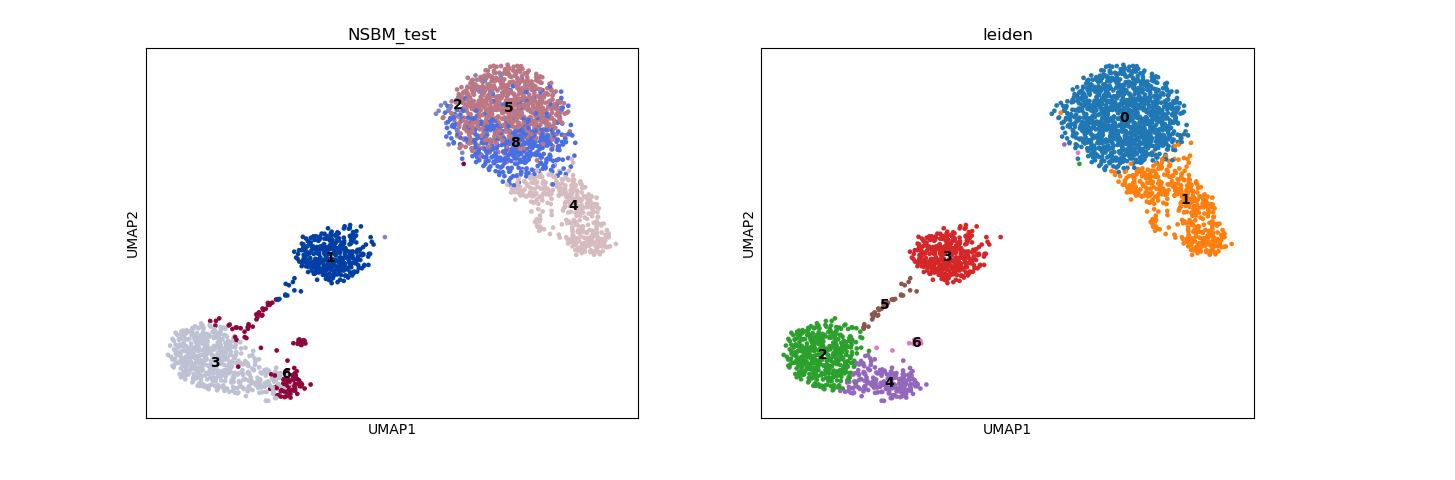

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
1,0,0,0,340,0,12,0
2,26,0,0,1,1,0,1
3,0,0,418,0,129,0,0
4,0,383,0,0,0,0,0
5,765,0,0,0,0,0,0
6,0,0,18,0,67,24,15
8,374,64,0,0,0,0,0


In [18]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(states2.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

# anneal state 2

In [13]:
bs = state2.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=state2.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=5,mcmc_equilibrate_args=dict(wait=1000,nbreaks=2,epsilon=0))
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state2_anneal100_5a_pbmc.pkl','wb'),2)
state

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


1555.1370148658752


<NestedBlockState object, with base <BlockState object with 265 blocks (164 nonempty), for graph <Graph object, undirected, with 2638 vertices and 65573 edges, 1 internal edge property, at 0x7f46dd087550>, at 0x7f467dc750d0>, and 10 levels of sizes [(2638, 164), (164, 30), (30, 11), (11, 6), (6, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f467ef42ad0>

In [14]:
state100_5a=pickle.load(open('beta_parameter/state2_anneal100_5a_pbmc.pkl','rb'))

<IPython.core.display.Javascript object>


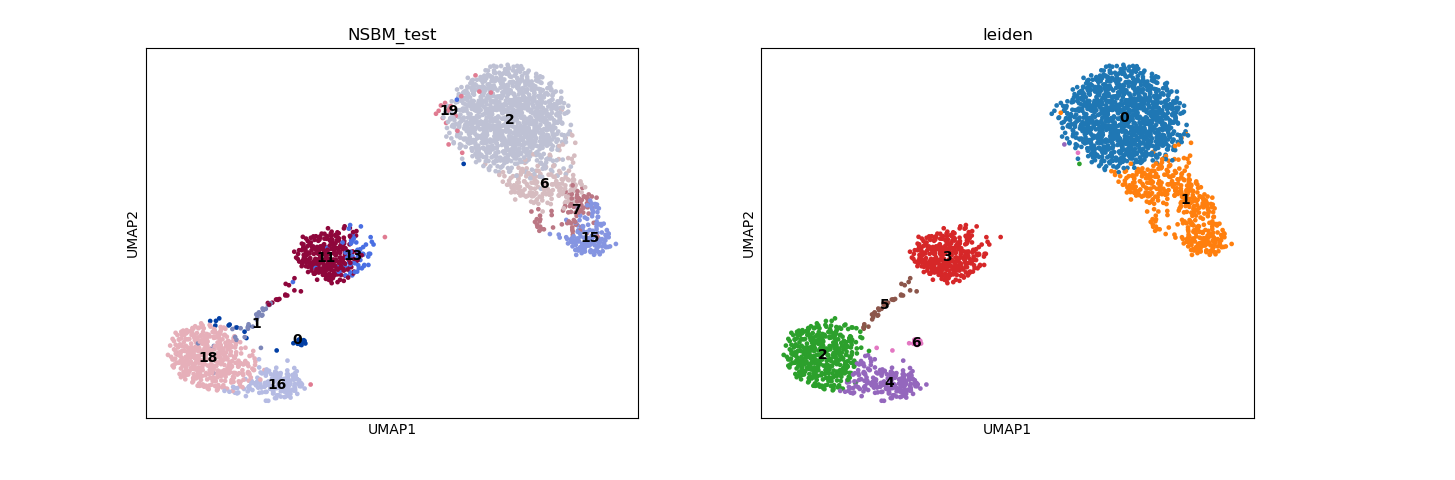

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,0,0,11,0,0,0,14
1,0,0,11,0,0,19,1
2,1138,36,0,0,0,0,0
6,10,183,0,0,0,0,0
7,0,83,0,0,0,0,0
11,0,0,0,280,0,16,0
13,1,0,0,60,0,1,0
15,0,145,0,0,0,0,0
16,0,0,0,0,157,0,0


In [15]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_5a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

# equilibrate

In [4]:
bs = state1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=state1.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_equilibrate(state,wait=1000, nbreaks=2,epsilon=0)
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state1_equilibrate_pbmc_no_niter.pkl','wb'),2)
state

498.27601957321167


<NestedBlockState object, with base <BlockState object with 268 blocks (158 nonempty), for graph <Graph object, undirected, with 2638 vertices and 65573 edges, 1 internal edge property, at 0x7ff4c0514590>, at 0x7ff45e7f21d0>, and 10 levels of sizes [(2638, 158), (158, 26), (26, 9), (9, 5), (5, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ff45e7f2150>

In [5]:
estate1=pickle.load(open('beta_parameter/state1_equilibrate_pbmc.pkl','rb'))

<IPython.core.display.Javascript object>


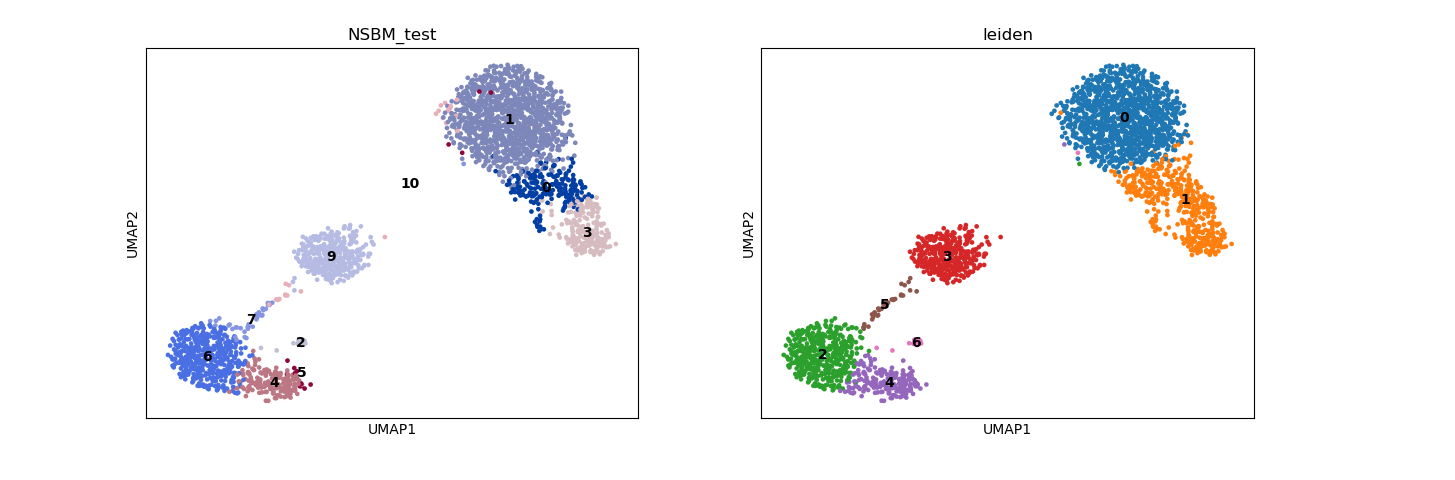

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,3,201,0,0,0,0,0
1,1146,46,0,0,0,0,0
2,0,0,0,0,0,0,15
3,0,200,0,0,0,0,0
4,0,0,1,0,165,0,0
5,2,0,0,0,12,0,1
6,0,0,418,0,20,0,0
7,0,0,17,0,0,21,0
9,1,0,0,340,0,3,0


In [6]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(estate1.project_level(3).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

### annela post equilibrate

In [7]:
bs = estate1.get_bs()                   
bs += [np.zeros(1)] * (10 - len(bs))

state=estate1.copy(bs=bs, sampling=True)
a=time.time()
gt.mcmc_anneal(state,beta_range=(1,100), niter=10)
b=time.time()
c=b-a
print(c)
pickle.dump(state,open('beta_parameter/state1_anneal100_10a_pbmc_post_equilibrate.pkl','wb'),2)
state

/home/morelli/anaconda3/envs/scrna/lib/python3.7/site-packages/graph_tool/inference/blockmodel.py:483: UserWarning: unrecognized keyword arguments: ['allow_empty']
  str(list(kwargs.keys())))


1903.5396783351898


<NestedBlockState object, with base <BlockState object with 269 blocks (161 nonempty), for graph <Graph object, undirected, with 2638 vertices and 65573 edges, 1 internal edge property, at 0x7ff47baba210>, at 0x7ff455f83b90>, and 10 levels of sizes [(2638, 161), (161, 31), (31, 12), (12, 6), (6, 3), (3, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7ff455f83890>

In [8]:
state100_10a=pickle.load(open('beta_parameter/state1_anneal100_10a_pbmc_post_equilibrate.pkl','rb'))

<IPython.core.display.Javascript object>


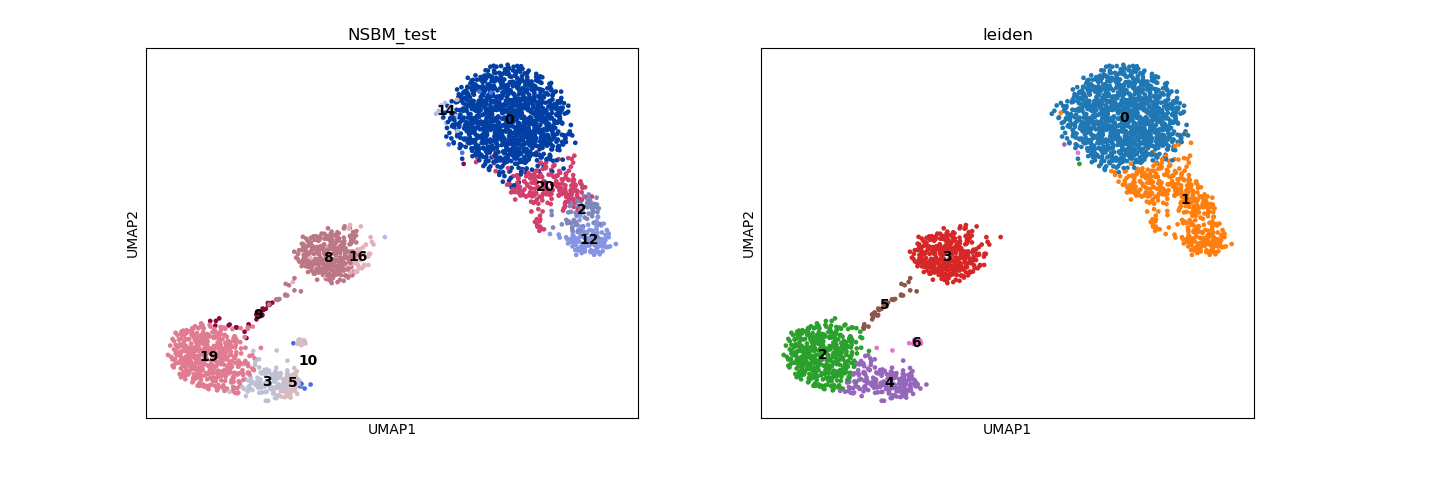

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
0,1142,39,0,0,0,0,0
2,0,72,0,0,0,0,0
3,0,0,1,0,101,0,0
5,0,0,0,0,54,0,13
8,0,0,0,299,0,14,0
9,0,0,12,0,0,18,0
10,2,1,0,0,7,0,2
12,0,127,0,0,0,0,0
14,12,0,0,1,0,0,0


In [12]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state100_10a.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)

# greedy

In [37]:
a=time.time()
bs=[np.zeros(1)] * (10)
state = gt.NestedBlockState(g,bs = bs)

state=state.copy(bs=bs, sampling=True)
gt.mcmc_anneal(state, beta_range=(1, 10), niter=1000, mcmc_equilibrate_args=dict(force_niter=10))
b=time.time()
print(a-b)
pickle.dump(state,open('beta_parameter/state_greedy_pbmc.pkl','wb'),2)
state

-40.71882605552673


<NestedBlockState object, with base <BlockState object with 2 blocks (1 nonempty), degree-corrected, for graph <Graph object, undirected, with 2638 vertices and 65573 edges at 0x7f68002f2c10>, at 0x7f6803272410>, and 10 levels of sizes [(2638, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)] at 0x7f68031c76d0>

In [7]:
state_greedy=pickle.load(open('beta_parameter/state_greedy_pbmc.pkl','rb'))

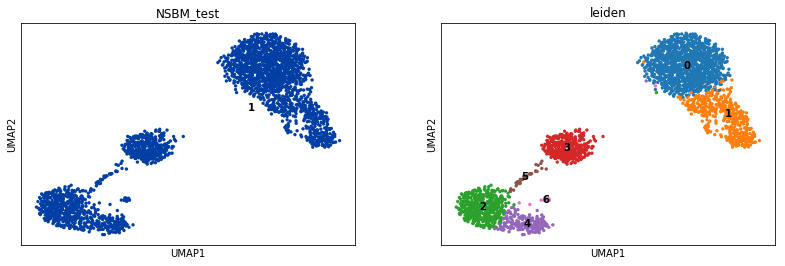

leiden,0,1,2,3,4,5,6
NSBM_test,,,,,,,
1,1165,447,436,341,197,36,16


In [8]:
adata.obs.loc[:, 'NSBM_test'] = pd.Categorical(list(state_greedy.project_level(2).get_blocks()))
sc.pl.umap(adata, color=["NSBM_test", 'leiden'], legend_loc='on data')
pd.crosstab(adata.obs.NSBM_test, adata.obs.leiden)